

# Tags Prediction from Stackoverflow Questions
Contributed by Aditya Gupta(aditya19138@iiitd.ac.in) and Deepak Gupta(deepak19158@iiitd.ac.in)






In [1]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re
import string 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download("stopwords")
nltk.download("wordnet")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,f1_score,hamming_loss,classification_report,precision_score,recall_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB,MultinomialNB
import pickle

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/ML Project/data.csv")
df

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents
...,...,...,...,...
199995,199996,"Why does perl warn that open my $fh, $file is ...","<p>It is my first day to perl, and I find this...",perl warnings suppress-warnings
199996,199997,Custom clipping path over HTML <div>,<p>After unsuccessful experimentation with SVG...,javascript jquery css svg mask
199997,199998,git alias for HEAD:refs/for/master,<p>I am configuring <code>Gerrit</code> and I ...,git gerrit
199998,199999,Can i prevent the keyboard to push things up w...,<p>I am using sencha touch beta 3 version at t...,android ios sencha-touch sencha sencha-touch-2


In [ ]:
# removing duplicates from dataset

df.drop_duplicates(subset=['Title', 'Body','Tags'],inplace=True)
df=df.dropna()
df

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents
...,...,...,...,...
199995,199996,"Why does perl warn that open my $fh, $file is ...","<p>It is my first day to perl, and I find this...",perl warnings suppress-warnings
199996,199997,Custom clipping path over HTML <div>,<p>After unsuccessful experimentation with SVG...,javascript jquery css svg mask
199997,199998,git alias for HEAD:refs/for/master,<p>I am configuring <code>Gerrit</code> and I ...,git gerrit
199998,199999,Can i prevent the keyboard to push things up w...,<p>I am using sencha touch beta 3 version at t...,android ios sencha-touch sencha sencha-touch-2


In [ ]:
#adding an extra col for number of tags in the tag column
df["tag_count"] = df["Tags"].apply(lambda x : len(x.split()))

Text(0, 0.5, 'Frequency')

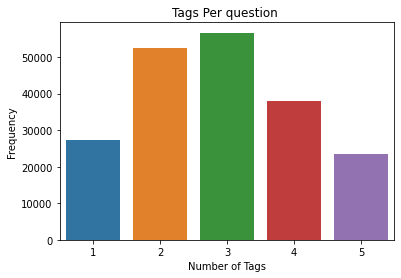

In [ ]:

sns.countplot(df["tag_count"])
plt.title("Tags Per question ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

In [ ]:
print( "Maximum number of tags per question: %d"%max(df["tag_count"]))
print( "Minimum number of tags per question: %d"%min(df["tag_count"]))
print( "Avg. number of tags per question: %f"% ((sum(df["tag_count"])*1.0)/len(df["tag_count"])))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.888066


Finding Unique Tags

In [ ]:


vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_matrix = vectorizer.fit_transform(df['Tags'])

In [ ]:
tag_matrix.shape

(197750, 23686)

In [ ]:
tags = pd.DataFrame(vectorizer.get_feature_names())
tags.columns=["Tag Name"]


In [ ]:
import numpy as np

freqs = pd.DataFrame(tag_matrix.sum(axis = 0).T)
freqs.columns=["Count"]

result = pd.concat([tags, freqs],axis=1)

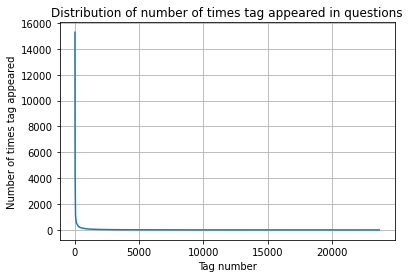

In [ ]:
tag_df_sorted=result.sort_values("Count",ascending=False)
plt.plot(tag_df_sorted["Count"].values)
plt.title("Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

We can see this is a very skewed distibution as most of the tags occur very rarely in the question and the remaining tags are the most frequent.

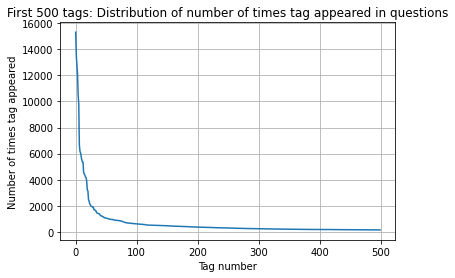

In [ ]:
plt.plot(tag_df_sorted["Count"].values[0:500])
plt.title('First 500 tags: Distribution of number of times tag appeared in questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

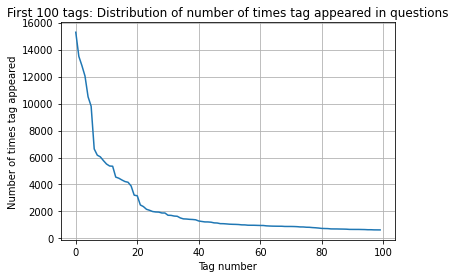

In [ ]:
plt.plot(tag_df_sorted["Count"].values[0:100])
plt.title('First 100 tags: Distribution of number of times tag appeared in questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()


In [ ]:
# tags greater than 10K
lst_tags_gt_10k = len(tag_df_sorted[tag_df_sorted.Count>1000])
#Print the length of the list
print (lst_tags_gt_10k,' Tags are used more than 10000 times')
# tags greater than 100K
lst_tags_gt_100k = len(tag_df_sorted[tag_df_sorted.Count>10000])
print (lst_tags_gt_100k,' Tags are used more than 100000 times')

56  Tags are used more than 10000 times
5  Tags are used more than 100000 times


<function matplotlib.pyplot.show>

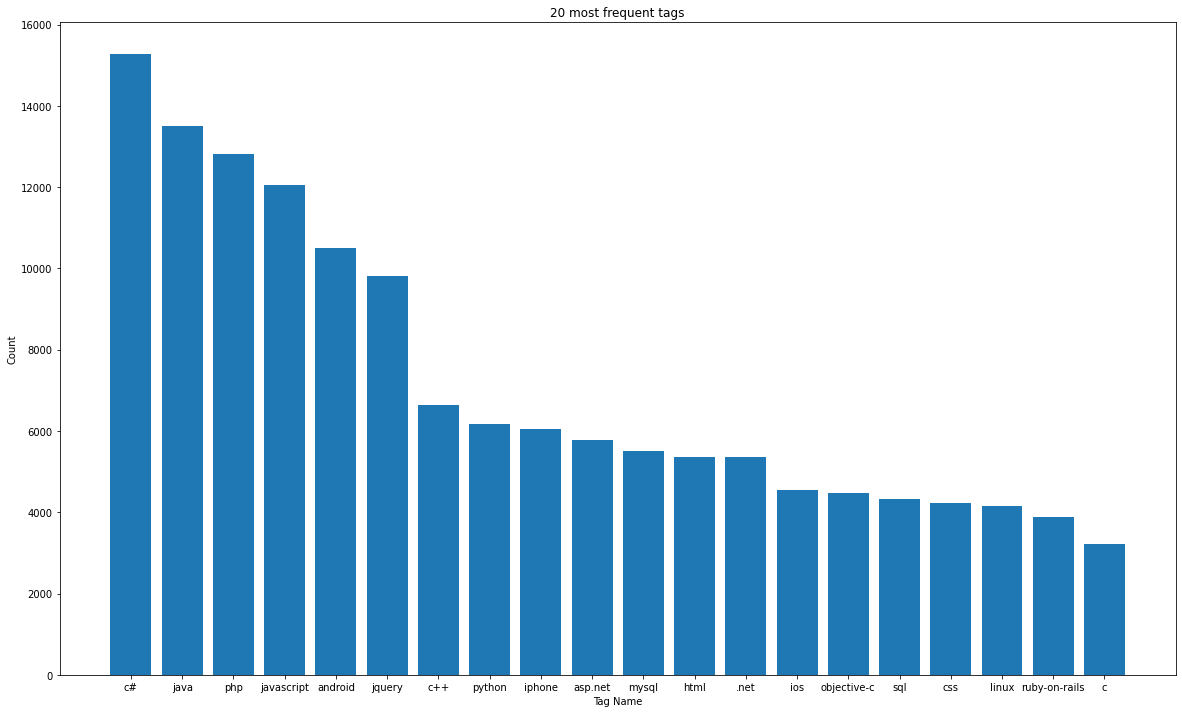

In [ ]:
plt.figure(figsize=(20,12))
plt.bar(tag_df_sorted.iloc[:20,0].values,tag_df_sorted.iloc[:20,1])
plt.title("20 most frequent tags")
plt.xlabel("Tag Name")
plt.ylabel("Count")
plt.show


> Most frequent tag is C#

> Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.







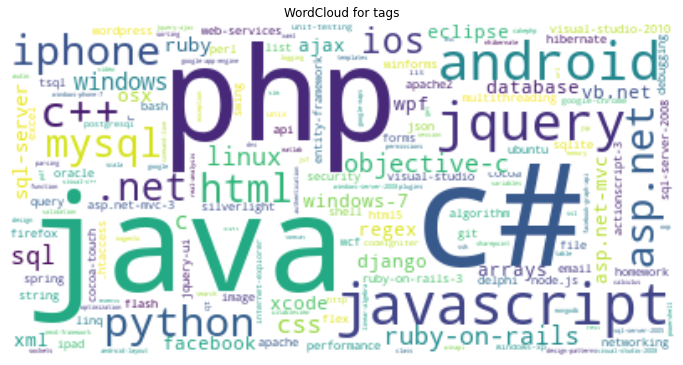

In [ ]:


arr1=result["Tag Name"].to_numpy()
arr2=result["Count"].to_numpy()
tag_freq=dict(zip(arr1,arr2))

word_cloud = WordCloud(collocations = False, background_color = 'white').generate_from_frequencies(tag_freq)
plt.figure(figsize=(12,12))
plt.imshow(word_cloud,interpolation="bilinear")
plt.title("WordCloud for tags")
plt.axis("off")
plt.show()

**Vectorizing tags for multilabel classification**

In [ ]:
vectorizer = CountVectorizer(tokenizer= lambda text : text.split(), binary=True)
multilabel_y = vectorizer.fit_transform(df["Tags"])
multilabel_y.shape

(197750, 23686)

Training Samples of tags

In [ ]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]    #now multilabel_y is a binary sparse matrix of tags where rows are data points and columns are tags names.
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)     #Now, "sorted_tags_i[:n]" will give index of top 'n' highest occurring tags.
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]     #multilabel_yn[:, sorted_tags_i[:n]] will give columns of top 'n' highest occuring tags of binary sparse matrix.
    return multilabel_yn


def questions_explained_fn(n):
  """multilabel_yn is a sparse binary matrix which contains only the columns of top 'n' highest occurring tags. 
  Now, multilabel_yn.sum(axis = 1) will sum() the rows of multilabel_yn sparse binary matrix.
  It means that when we choose only the top 'n' highest occurring tags then there will be few questions which might contain 
  the tags which are occurring very few times and those tags will be removed. Hence, the row sum for those points will
  become zero. So, by counting the number of nonzero points we will get to know how many questions will be covered by taking 
  top 'n' highest occurring tags."""
  multilabel_yn = tags_to_choose(n) 
  x= multilabel_yn.sum(axis=1)
  return (np.count_nonzero(x==0))



In [ ]:
questions_explained = []
numberOfTags = []
total_tags=multilabel_y.shape[1]
total_qs=df.shape[0]

# for 100 tags
questions_explained.append(np.round(((total_qs-questions_explained_fn(100))/total_qs)*100,3))
numberOfTags.append(100)
for i in range(500, total_tags, 1500):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))
    numberOfTags.append(i)

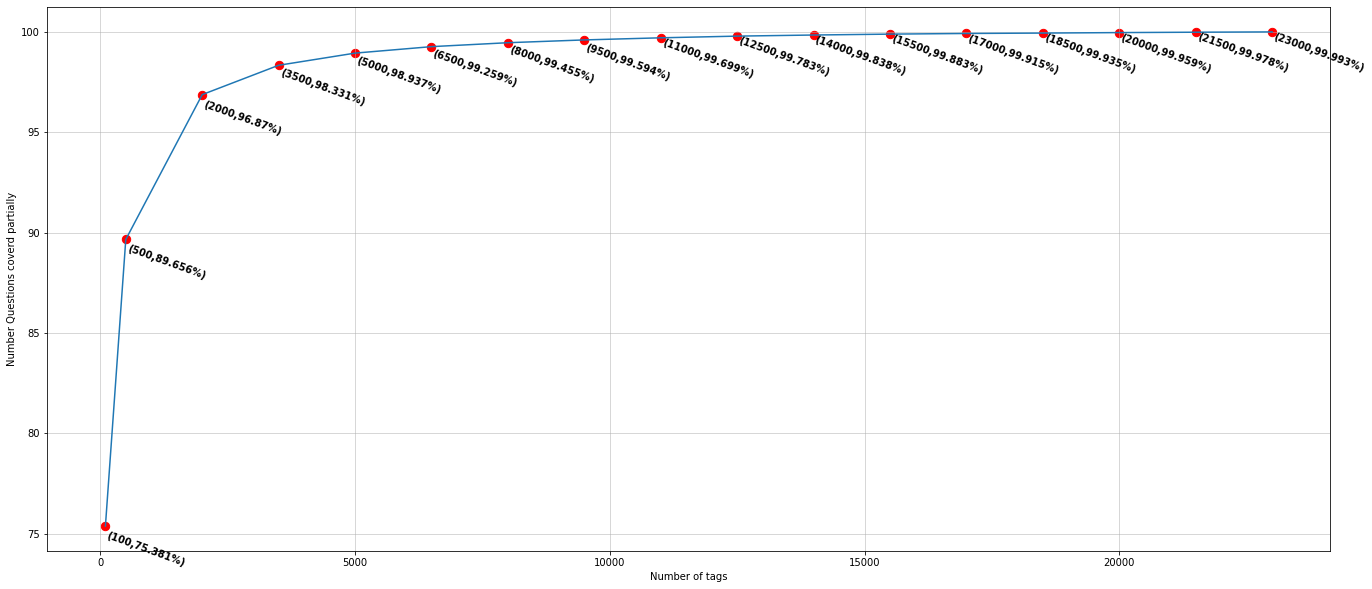

In [ ]:

fig, ax = plt.subplots(figsize = (23,10))
ax.plot(numberOfTags, questions_explained)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.scatter(x = numberOfTags, y = questions_explained, c = "red", s = 70)
for x, y in zip(numberOfTags, questions_explained):
    plt.annotate(s = '({},{}%)'.format(x, y), xy = (x, y), xytext=(x,y-2), fontweight='bold', fontsize = 10, rotation = -20)
plt.grid(linestyle='-', linewidth=0.5)
plt.show()

> with  100 tags we are covering  75.381 % of questions

for simplicity we will only take most frequent 500 tags

In [ ]:

final_tags=tag_df_sorted.iloc[:100,0].values

# now we will select only those questions with these 100 tags
idx_to_del=[]
for index,row in df.iterrows():
  tag_names=row["Tags"].split()
  for tag in tag_names:
    if tag not in final_tags:
      idx_to_del.append(index)
      break

df.drop(index=idx_to_del,inplace=True)

In [ ]:
pd.set_option('display.max_colwidth', None)
df

,Id,Title,Body,Tags,tag_count
1,2,How can I prevent firefox from closing when I press ctrl-w,"<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quite often happens to me that firefox is the active window (on windows) while I still look at vim (thinking vim is the active window) and press ctrl-w which closes firefox. This is not what I want. Is there a way to stop ctrl-w from closing firefox?</p>\n\n<p>Rene</p>\n",firefox,1
14,15,Can I stop windows 7 from fading windows on alt-tab?,"<p>When you hit alt tab on windows 7 and stop for a second on a window, it hides all other windows. Is there any way to tell Windows 7 to use the old classic behavior?</p>\n",windows-7,1
21,22,Get all +ve number count in LINQ,"<p>I am using the following thing:</p>\n\n<pre><code>int[] a = {1, 2, 3, 0, 5, 0};\nint x = a.Select(b =&gt; b != 0).Count(); \n</code></pre>\n\n<p>I am getting <strong>6</strong> as the value, how can I get <strong>4</strong> instead of <strong>6</strong>.</p>\n\n<p>Can someone please guid me.</p>\n",c# .net linq,3
40,41,implementing Static library in New iphone App,"<p>I have created a static library libTest.a.</p>\n\n<ol>\n<li>i am added that library into my new project.</li>\n<li>After that i added the header search path and Library search path.</li>\n<li><p>And i added -ObjC -all_load in OtherlinkerFlag.</p>\n\n<p>In Simulator everything works fine... In device i am facing a error ""_OBJC_CLASS_$_Test"", referenced from:\nHow to fix this issue ? Pls help me.. </p></li>\n</ol>\n",iphone xcode,2
56,57,"<textarea/> tag ""swallows"" html","<p>This is a very strange problem I've been struggling with for a few days. At first I thought it was related to something in our application, but I've stripped it down to the simplest html page and it's still happening. Basically anytime I add a tag to a page the html after it gets rendered as it's value. fixes the issue, but I don't understand why. I'm at a loss here, it has to be something really simple that I just don't know.</p>\n\n<p>In the following example the paragraph tags show up as the value of the textarea. </p>\n\n<p>I'm using IE8.</p>\n\n<pre><code>&lt;html&gt;\n&lt;head&gt;\n &lt;title&gt;About&lt;/title&gt;\n&lt;/head&gt;\n&lt;body&gt;\n\n &lt;textarea/&gt;\n &lt;p align=""center""&gt;\n test\n &lt;/p&gt;\n &lt;p align=""left""&gt;\n test\n &lt;/p&gt;\n\n\n&lt;/body&gt;\n</code></pre>\n\n<p></p>\n",html,1
...,...,...,...,...,...
199980,199981,XCode4 : Changing BundleID,"<p>I created an app which called say Foo in XCode. </p>\n\n<p>When I decided to publish this app, I wanted to name the app FooApp instead of Foo. So, that is the bundleID that was created.</p>\n\n<p>The problem now is that the bundle ID's in XCode vs. iTunesConnect do not match.</p>\n\n<p>I tried to edit info.plist but it seems to mess up my project and it will no longer run at all.</p>\n\n<p>Any suggestions?</p>\n",iphone,1
199981,199982,C# service with Oracle .NET provider gets slower and slower,"<p>I have a C# service written for .NET 2.0 that uses the Oracle data access provider for .NET 2.102.2.20. The service runs multiple threads and runs lots of queries to an Oracle 9.2 database. I am using NHibernate.</p>\n\n<p>What I am seeing is that when it starts up it runs fast, then gets slower and slower. The CPU usage starts low then goes up and up. After a few minutes it is crawling and the CPU is at 100%. I have looked in my code and find nothing that could be doing this. Percent time in GC is &lt; 5%. I have tried varying the ODP.NET parameters to no avail.</p>\n\n<p>Anyone have an idea what could be doing this?</p>\n\n<p>More detail:\nThe threads are worker threads and need to keep running all the time. I have no runaway threads, they are doing real work. I have profiled the program and it looks like it is spending a lot of its time inside the Oracle provider, which you would expect, but why would it use so much CPU? It's as if it's spinning waiting for resultset

### Data Preprocessing


1. Removed HTML Tags using Regular Expressions
2. Converted all the characters into small letters
3. Separated code-snippets from Body
4. Removed URL links from the body
5. Removed Special characters from Question title and description 
6. Removed stop words (Except ‘C’)
7. Lemmatized the words to take only meaningful words
8. Removed contracted word to thier full form



In [ ]:


def remove_markup(text):
  regex=re.compile('<.*?>')
  return re.sub(regex,'',text)
  return out

def decontract(sentence):
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence


def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmedSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmedSentence += stem
        stemmedSentence += " "
    stemmedSentence = stemmedSentence.strip()
    return stemmedSentence

dict_list=[]

for index,row in df.iterrows():
  #since title is more important, it is given more wieght
  title,body,tags= 3*row["Title"],row["Body"],row["Tags"]

  #combining title and body to form question
  question= title + body
  question=question.lower() 

  # seperate the code block from the question
  code=str(re.findall('<code>(.*?)</code>',question,flags=re.DOTALL)) 

  #removing the code block from the questions
  question=re.sub('<code>(.*?)</code>',' ',question,flags=re.MULTILINE)

  #question pre-processing
  question=remove_markup(question)
  question=decontract(question)
  question= re.sub("(w+://S+)", " ", question)  # removing URLs
  word_list = nltk.word_tokenize(question)
  question=" ".join([i for i in word_list if i not in string.punctuation]) #removing special-char
  stopwords = nltk.corpus.stopwords.words('english')
  word_list = nltk.word_tokenize(question)
  question= " ".join([i for i in word_list if (i not in stopwords or i=="c")])   # removing stopwords
  question=stemming(question)

  pre_dict={
      "Question": question,
      "Code": code,
      "Tag": tags
  }

  dict_list.append(pre_dict)

processed_df=pd.DataFrame(dict_list)


Dataset after processing

In [ ]:
processed_df.head()

,Question,Code,Tag
0,prevent firefox close press ctrl-whow prevent firefox close press ctrl-whow prevent firefox close press ctrl-win favorit editor vim regular use ctrl-w execut certain action quit often happen firefox activ window window still look vim think vim activ window press ctrl-w close firefox want way stop ctrl-w close firefox rene,[],firefox
1,stop window 7 fade window alt-tab stop window 7 fade window alt-tab stop window 7 fade window alt-tab hit alt tab window 7 stop second window hide window way tell window 7 use old classic behavior,[],windows-7
2,get +ve number count linqget +ve number count linqget +ve number count linqi use follow thing int 1 2 3 0 5 0 int x a.select b gt b 0 .count get 6 valu get 4 instead 6. someon pleas guid,"['int[] a = {1, 2, 3, 0, 5, 0};\nint x = a.select(b =&gt; b != 0).count(); \n']",c# .net linq
3,implement static librari new iphon appimpl static librari new iphon appimpl static librari new iphon appi creat static librari libtest.a ad librari new project ad header search path librari search path ad -objc -all_load otherlinkerflag simul everyth work fine ... devic face error `` _objc_class_ _test '' referenc fix issu pls help me..,[],iphone xcode
4,tag `` swallow '' html tag `` swallow '' html tag `` swallow '' htmlthis strang problem struggl day first thought relat someth applic strip simplest html page still happen basic anytim add tag page html get render valu fix issu understand loss someth realli simpl know follow exampl paragraph tag show valu textarea use ie8 lt html gt lt head gt lt titl gt lt /titl gt lt /head gt lt bodi gt lt textarea/ gt lt p align= '' center '' gt test lt /p gt lt p align= '' left '' gt test lt /p gt lt /bodi gt,"['&lt;html&gt;\n&lt;head&gt;\n &lt;title&gt;about&lt;/title&gt;\n&lt;/head&gt;\n&lt;body&gt;\n\n &lt;textarea/&gt;\n &lt;p align=""center""&gt;\n test\n &lt;/p&gt;\n &lt;p align=""left""&gt;\n test\n &lt;/p&gt;\n\n\n&lt;/body&gt;\n']",html


Actual Dataset

In [ ]:
df

,Id,Title,Body,Tags,tag_count
1,2,How can I prevent firefox from closing when I press ctrl-w,"<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quite often happens to me that firefox is the active window (on windows) while I still look at vim (thinking vim is the active window) and press ctrl-w which closes firefox. This is not what I want. Is there a way to stop ctrl-w from closing firefox?</p>\n\n<p>Rene</p>\n",firefox,1
14,15,Can I stop windows 7 from fading windows on alt-tab?,"<p>When you hit alt tab on windows 7 and stop for a second on a window, it hides all other windows. Is there any way to tell Windows 7 to use the old classic behavior?</p>\n",windows-7,1
21,22,Get all +ve number count in LINQ,"<p>I am using the following thing:</p>\n\n<pre><code>int[] a = {1, 2, 3, 0, 5, 0};\nint x = a.Select(b =&gt; b != 0).Count(); \n</code></pre>\n\n<p>I am getting <strong>6</strong> as the value, how can I get <strong>4</strong> instead of <strong>6</strong>.</p>\n\n<p>Can someone please guid me.</p>\n",c# .net linq,3
40,41,implementing Static library in New iphone App,"<p>I have created a static library libTest.a.</p>\n\n<ol>\n<li>i am added that library into my new project.</li>\n<li>After that i added the header search path and Library search path.</li>\n<li><p>And i added -ObjC -all_load in OtherlinkerFlag.</p>\n\n<p>In Simulator everything works fine... In device i am facing a error ""_OBJC_CLASS_$_Test"", referenced from:\nHow to fix this issue ? Pls help me.. </p></li>\n</ol>\n",iphone xcode,2
56,57,"<textarea/> tag ""swallows"" html","<p>This is a very strange problem I've been struggling with for a few days. At first I thought it was related to something in our application, but I've stripped it down to the simplest html page and it's still happening. Basically anytime I add a tag to a page the html after it gets rendered as it's value. fixes the issue, but I don't understand why. I'm at a loss here, it has to be something really simple that I just don't know.</p>\n\n<p>In the following example the paragraph tags show up as the value of the textarea. </p>\n\n<p>I'm using IE8.</p>\n\n<pre><code>&lt;html&gt;\n&lt;head&gt;\n &lt;title&gt;About&lt;/title&gt;\n&lt;/head&gt;\n&lt;body&gt;\n\n &lt;textarea/&gt;\n &lt;p align=""center""&gt;\n test\n &lt;/p&gt;\n &lt;p align=""left""&gt;\n test\n &lt;/p&gt;\n\n\n&lt;/body&gt;\n</code></pre>\n\n<p></p>\n",html,1
...,...,...,...,...,...
199980,199981,XCode4 : Changing BundleID,"<p>I created an app which called say Foo in XCode. </p>\n\n<p>When I decided to publish this app, I wanted to name the app FooApp instead of Foo. So, that is the bundleID that was created.</p>\n\n<p>The problem now is that the bundle ID's in XCode vs. iTunesConnect do not match.</p>\n\n<p>I tried to edit info.plist but it seems to mess up my project and it will no longer run at all.</p>\n\n<p>Any suggestions?</p>\n",iphone,1
199981,199982,C# service with Oracle .NET provider gets slower and slower,"<p>I have a C# service written for .NET 2.0 that uses the Oracle data access provider for .NET 2.102.2.20. The service runs multiple threads and runs lots of queries to an Oracle 9.2 database. I am using NHibernate.</p>\n\n<p>What I am seeing is that when it starts up it runs fast, then gets slower and slower. The CPU usage starts low then goes up and up. After a few minutes it is crawling and the CPU is at 100%. I have looked in my code and find nothing that could be doing this. Percent time in GC is &lt; 5%. I have tried varying the ODP.NET parameters to no avail.</p>\n\n<p>Anyone have an idea what could be doing this?</p>\n\n<p>More detail:\nThe threads are worker threads and need to keep running all the time. I have no runaway threads, they are doing real work. I have profiled the program and it looks like it is spending a lot of its time inside the Oracle provider, which you would expect, but why would it use so much CPU? It's as if it's spinning waiting for resultset

In [ ]:
vectorizer = CountVectorizer(tokenizer= lambda text : text.split(), binary=True)
multilabel_y = vectorizer.fit_transform(processed_df["Tag"])
multilabel_y.shape

(31048, 100)

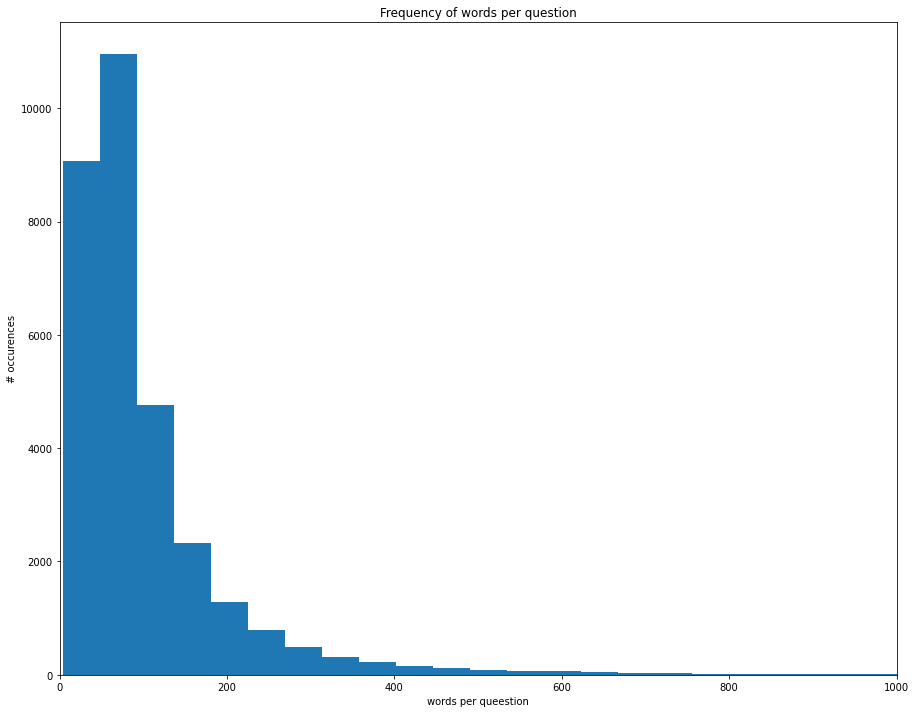

In [ ]:
word_count=[]
for i,ques in enumerate(processed_df["Question"]):
  word_count.append(len(ques.split()))

word_count=np.array(word_count)
plt.figure(figsize=(15,12))
plt.hist(word_count,bins=200)
plt.xlim((0,1000))
plt.gca().set(title="Frequency of words per question",xlabel="words per queestion",ylabel="# occurences")
plt.show()

## Modelling

In [4]:
processed_df=pd.read_csv("/content/drive/MyDrive/ML Project/processed_questions.csv")

### Feature Extraction & Selection

In [5]:

vect=TfidfVectorizer( smooth_idf=True, norm="l2",max_features=200000, tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
X=vect.fit_transform(processed_df["Question"])


In [6]:
X.shape

(31048, 200000)

In [7]:
vectorizer = CountVectorizer(tokenizer= lambda text : text.split(), binary=True)
multilabel_y = vectorizer.fit_transform(processed_df["Tag"])
multilabel_y.shape

(31048, 100)

In [11]:
# top 10000 feature selection using univariate feature selection
sel=SelectKBest(chi2,k=1000)
X_new=sel.fit_transform(X,multilabel_y)
X_new.shape


(31048, 1000)

In [13]:

X_train, X_test, y_train, y_test = train_test_split(X_new, multilabel_y, test_size=0.2, shuffle=True)

### SGD Classifier

Train Macro f1 score : 0.2862038560221782
Train Micro f1 scoore : 0.45786485043599245
Tain Hamming loss : 0.013491827039214107
Test Macro f1 score : 0.2815699119960413
Test Micro f1 scoore : 0.4523045320323532
Test Hamming loss : 0.013739130434782608
------------------------------------------------------------------------
Train Macro f1 score : 0.5608176906519274
Train Micro f1 scoore : 0.6464919789049342
Tain Hamming loss : 0.010309203639584508
Test Macro f1 score : 0.4782437266213264
Test Micro f1 scoore : 0.5922211077677476
Test Hamming loss : 0.011784219001610306
------------------------------------------------------------------------
Train Macro f1 score : 0.8551274733215954
Train Micro f1 scoore : 0.812623666886519
Tain Hamming loss : 0.0060620822932603265
Test Macro f1 score : 0.5098971647766343
Test Micro f1 scoore : 0.6133040935672515
Test Hamming loss : 0.011925925925925927
------------------------------------------------------------------------
Train Macro f1 score : 0.92472

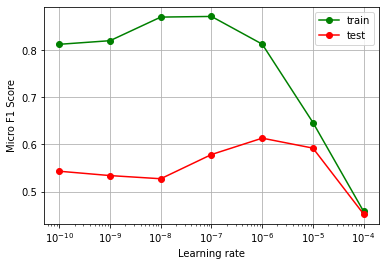

In [ ]:

alpha = [10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10]
train_f1=[]
test_f1=[]

for i in alpha:
  clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1'), n_jobs=-1)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  train_f1.append(f1_score(y_train, clf.predict(X_train) , average = 'micro'))
  test_f1.append(f1_score(y_test, y_pred, average = 'micro'))
  print("Train Macro f1 score :",f1_score(y_train, clf.predict(X_train) , average = 'macro'))
  print("Train Micro f1 scoore :",f1_score(y_train, clf.predict(X_train), average = 'micro'))
  print("Tain Hamming loss :",hamming_loss(y_train,clf.predict(X_train)))
  # print("Test set Accuracy :",accuracy_score(y_test,y_pred))
  print("Test Macro f1 score :",f1_score(y_test, y_pred, average = 'macro'))
  print("Test Micro f1 scoore :",f1_score(y_test, y_pred, average = 'micro'))
  print("Test Hamming loss :",hamming_loss(y_test,y_pred))
  print("------------------------------------------------------------------------")

plt.plot(alpha, train_f1, 'o-', color='green', label='train')
plt.plot(alpha, test_f1, 'o-', color='red', label='test')
plt.xscale('log')
plt.legend()
plt.grid()
plt.xlabel('Learning rate')
plt.ylabel('Micro F1 Score')
plt.show()


In [ ]:
# with 200000 features without vocab

clf=OneVsRestClassifier(SGDClassifier(loss='log', alpha=10**-7, penalty='l1'), n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

# print("Train Set Accuracy:",accuracy_score(y_train,clf.predict(X_train)))
print("Train Macro f1 score :",f1_score(y_train, clf.predict(X_train) , average = 'macro'))
print("Train Micro f1 scoore :",f1_score(y_train, clf.predict(X_train), average = 'micro'))
print("Tain Hamming loss :",hamming_loss(y_train,clf.predict(X_train)))
# print("Test set Accuracy :",accuracy_score(y_test,y_pred))
print("Test Macro f1 score :",f1_score(y_test, y_pred, average = 'macro'))
print("Test Micro f1 scoore :",f1_score(y_test, y_pred, average = 'micro'))
print("Test Hamming loss :",hamming_loss(y_test,y_pred))
print(classification_report(y_test,y_pred))
pickle.dump(clf,open("/content/drive/MyDrive/ML Project/sgdc.pkl",'wb'))

Train Macro f1 score : 0.9258080435047217
Train Micro f1 scoore : 0.8738758756183415
Tain Hamming loss : 0.004342137048071504
Test Macro f1 score : 0.49850178896851605
Test Micro f1 scoore : 0.5806330421715037
Test Hamming loss : 0.014380032206119163
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        27
           1       0.26      0.23      0.25       194
           2       0.65      0.45      0.53        44
           3       0.52      0.49      0.51       133
           4       0.40      0.21      0.28        28
           5       0.85      0.84      0.85       482
           6       0.45      0.34      0.39        29
           7       0.42      0.29      0.34        17
           8       0.50      0.12      0.20        16
           9       0.37      0.41      0.39        87
          10       0.59      0.55      0.57       375
          11       0.55      0.61      0.57       114
          12       0.52      0.53      0.52   

### Logistic Regression

Train Set micro F1: 0.5756090444930707
Tain Hamming loss : 0.011712698284886061
Test set micro F1 : 0.5572093023255814
Test Hamming loss : 0.012264090177133655
--------------------------------------------------------------
Train Set micro F1: 0.7127396044456807
Tain Hamming loss : 0.00873057412029954
Test set micro F1 : 0.6072596468279923
Test Hamming loss : 0.011603864734299517
--------------------------------------------------------------
Train Set micro F1: 0.8052397801701422
Tain Hamming loss : 0.006249295434415009
Test set micro F1 : 0.616082130387201
Test Hamming loss : 0.011863123993558777
--------------------------------------------------------------
Train Set micro F1: 0.8367985416564023
Tain Hamming loss : 0.005334568000644174
Test set micro F1 : 0.6118244100482111
Test Hamming loss : 0.012317230273752013
--------------------------------------------------------------
Train Set micro F1: 0.8558230002431315
Tain Hamming loss : 0.004774941621708672
Test set micro F1 : 0.60729752

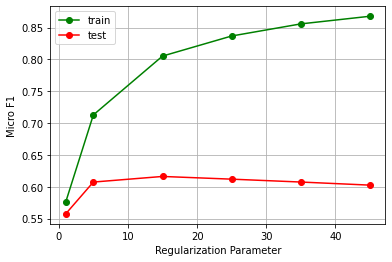

In [ ]:

C=[1,5,15,25,35,45]
f1_train=[]
f1_test=[]

for c in C:
  clf=OneVsRestClassifier(LogisticRegression(penalty='l1',C=c,solver='liblinear'), n_jobs=-1)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  f1_train.append(f1_score(y_train,clf.predict(X_train),average="micro"))
  f1_test.append(f1_score(y_test,y_pred,average="micro"))
  print("Train Set micro F1:",f1_train[len(f1_train)-1])
  print("Tain Hamming loss :",hamming_loss(y_train,clf.predict(X_train)))
  print("Test set micro F1 :",f1_test[len(f1_test)-1])
  # print("Macro f1 score :",f1_score(y_test, y_pred, average = 'macro'))
  # print("Micro f1 scoore :",f1_score(y_test, y_pred, average = 'micro'))
  print("Test Hamming loss :",hamming_loss(y_test,y_pred))
  print('--------------------------------------------------------------')
# print(classification_report(y_test,y_pred))

plt.plot(C, f1_train, 'o-', color='green', label='train')
plt.plot(C, f1_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Micro F1')
plt.show()

Train Set micro F1: 0.4113257691914545
Tain Hamming loss : 0.013911748127868589
Test set micro F1 : 0.39354488744236504
Test Hamming loss : 0.014402576489533012
--------------------------------------------------------------
Train Set micro F1: 0.6888309133873325
Tain Hamming loss : 0.009171833480956598
Test set micro F1 : 0.5785282656576496
Test Hamming loss : 0.012017713365539452
--------------------------------------------------------------
Train Set micro F1: 0.7317357341453727
Tain Hamming loss : 0.008157661647475643
Test set micro F1 : 0.5913072402705399
Test Hamming loss : 0.011871175523349436
--------------------------------------------------------------
Train Set micro F1: 0.7559405361114363
Tain Hamming loss : 0.007554956115629278
Test set micro F1 : 0.5965220253442317
Test Hamming loss : 0.011843800322061192
--------------------------------------------------------------
Train Set micro F1: 0.770507837636097
Tain Hamming loss : 0.007179322006602786
Test set micro F1 : 0.599553

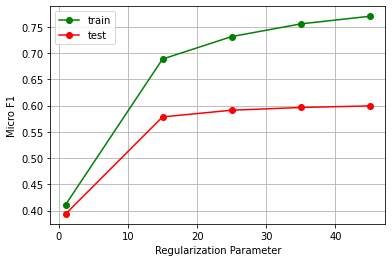

In [ ]:

C=[1,15,25,35,45]
f1_train=[]
f1_test=[]

for c in C:
  clf=OneVsRestClassifier(LogisticRegression(penalty='l2',C=c,solver='liblinear'), n_jobs=-1)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  f1_train.append(f1_score(y_train,clf.predict(X_train),average="micro"))
  f1_test.append(f1_score(y_test,y_pred,average="micro"))
  print("Train Set micro F1:",f1_train[len(f1_train)-1])
  print("Tain Hamming loss :",hamming_loss(y_train,clf.predict(X_train)))
  print("Test set micro F1 :",f1_test[len(f1_test)-1])
  # print("Macro f1 score :",f1_score(y_test, y_pred, average = 'macro'))
  # print("Micro f1 scoore :",f1_score(y_test, y_pred, average = 'micro'))
  print("Test Hamming loss :",hamming_loss(y_test,y_pred))
  print('--------------------------------------------------------------')
# print(classification_report(y_test,y_pred))

plt.plot(C, f1_train, 'o-', color='green', label='train')
plt.plot(C, f1_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Micro F1')
plt.show()

In [ ]:

clf=OneVsRestClassifier(LogisticRegression(penalty='none'), n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
# f1_train.append(f1_score(y_train,clf.predict(X_train),average="micro"))
# f1_test.append(f1_score(y_test,y_pred,average="micro"))
print("Train Set micro F1:",f1_score(y_train,clf.predict(X_train),average="micro"))
print("Tain Hamming loss :",hamming_loss(y_train,clf.predict(X_train)))
print("Test Set micro F1 :",f1_score(y_test,y_pred,average="micro"))
# print("Macro f1 score :",f1_score(y_test, y_pred, average = 'macro'))
# print("Micro f1 scoore :",f1_score(y_test, y_pred, average = 'micro'))
print("Test Hamming loss :",hamming_loss(y_test,y_pred))
print(classification_report(y_test,y_pred))


Train Set micro F1: 0.8687596743510062
Tain Hamming loss : 0.004471777115709799
Test Set micro F1 : 0.5737635620684797
Test Hamming loss : 0.014613526570048309
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        27
           1       0.29      0.20      0.24       194
           2       0.51      0.50      0.51        44
           3       0.60      0.53      0.56       133
           4       0.12      0.11      0.11        28
           5       0.86      0.83      0.84       482
           6       0.36      0.34      0.35        29
           7       0.33      0.18      0.23        17
           8       0.50      0.12      0.20        16
           9       0.35      0.30      0.32        87
          10       0.69      0.53      0.60       375
          11       0.48      0.55      0.52       114
          12       0.40      0.50      0.44        62
          13       0.56      0.77      0.65        43
          14       0.43      

In [ ]:
pickle.dump(clf,open("/content/drive/MyDrive/ML Project/logistic.pkl",'wb'))

In [ ]:
tags=np.array(y_pred.sum(axis=1))
np.count_nonzero(tags==0)

750

> Our model is predicting 1439 questions with no tags. So this is a problem !

In [ ]:
prob=clf.predict_proba(X_test)
thresholds= np.arange(0,1,0.01)
f1_scores=[]

for th in thresholds:
  labels =(prob>th).astype('int')
  f1= f1_score(y_test,labels,average="micro")
  f1_scores.append(f1)



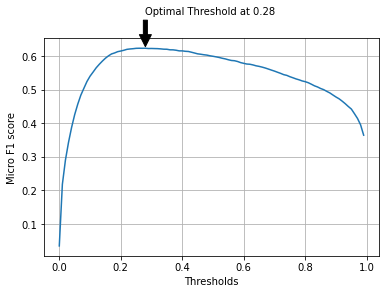

In [ ]:
# plt.figure(figsize=(8,12))
plt.plot(thresholds,f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('Micro F1 score')
ymax=max(f1_scores)
xpos=f1_scores.index(ymax)
xmax=thresholds[xpos]
plt.annotate(f"Optimal Threshold at %s"%xmax,xy=(xmax,ymax),xytext=(xmax, ymax+0.1),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

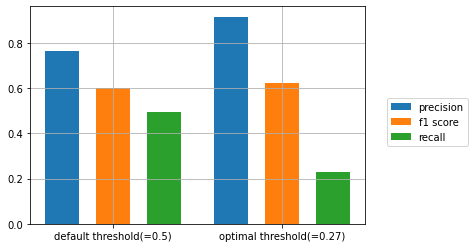

In [ ]:

x1=[precision_score(y_test,y_pred,average="micro"),precision_score(y_test,labels,average="micro")]
x2=[f1_score(y_test,y_pred,average="micro"),ymax]
x3=[recall_score(y_test,y_pred,average="micro"),recall_score(y_test,labels,average="micro")]
axis=np.arange(len(x1))

plt.bar(axis-0.3,x1,0.2,label="precision")
plt.bar(axis,x2,0.2,label="f1 score")
plt.bar(axis+0.3,x3,0.2,label="recall")
plt.xticks(axis,["default threshold(=0.5)", "optimal threshold(=0.27)"])
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.grid()
plt.show()

### Random Forest Classifier


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

# for train_index, val_index in kf.split(X_train):
f1train=[]
f1text=[]

stp  = [100,200,300,400]
BestModel = []
scr = 0
for estimate in stp:


  classifier = OneVsRestClassifier(RandomForestClassifier( n_estimators=estimate ,random_state=0, max_depth = 15))
  classifier.fit(X_train,y_train)
  y_pred = classifier.predict(X_test)
  ftrn = f1_score(y_train, classifier.predict(X_train), average='micro')
  ftst = f1_score(y_test, y_pred, average='micro')
  if(ftst>scr):
    scr =ftst
    BestModel = classifier
  print("estimator; ",estimate); 
  print("accuracy train: ",ftrn)
  print("accuracy test: ",ftst)
  print("Test Hamming loss :",hamming_loss(y_test,y_pred))
  print('--------------------------------------------------------------')
  f1train.append(ftrn)
  f1text.append(ftst)


plt.plot(stp,f1train)
plt.plot(stp,f1text)
# plt.xscale('log')
plt.title("before tuning max depth")
plt.xlabel('n_estimators')
plt.ylabel('F1 score')
plt.show()

In [ ]:
import joblib
joblib.dump(BestModel,'RandomForest.pkl')

In [3]:
import joblib
BestModel = joblib.load('/content/drive/MyDrive/ML Project/RandomForest.pkl')

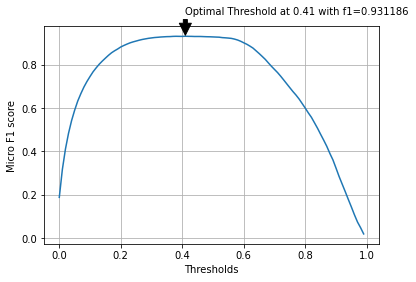

In [16]:
prob=BestModel.predict_proba(X_test)
thresholds= np.arange(0,1,0.01)
f1_scores=[]

for th in thresholds:
  labels =(prob>th).astype('int')
  f1= f1_score(y_test,labels,average="micro")
  f1_scores.append(f1)

  
plt.plot(thresholds,f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('Micro F1 score')
ymax=max(f1_scores)
xpos=f1_scores.index(ymax)
xmax=thresholds[xpos]
plt.annotate(f"Optimal Threshold at %s with f1=%f"%(round(xmax,2),ymax),xy=(xmax,ymax),xytext=(xmax, ymax+0.1),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

### K-Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
f1train=[]
f1text=[]
BestModel = []
scr = 0

stp  = [100,200,300,400]
for neigh in stp:

  classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=neigh))
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  
  ftrn = f1_score(y_train, classifier.predict(X_train), average='micro')
  ftst = f1_score(y_test, y_pred, average='micro')
  if(ftst>scr):
    scr =ftst
    BestModel = classifier
  print("estimator; ",estimate); 
  print("accuracy train: ",ftrn)
  print("accuracy test: ",ftst)
  print("Test Hamming loss :",hamming_loss(y_test,y_pred))
  print('--------------------------------------------------------------')
  f1train.append(ftrn)
  f1text.append(ftst)

plt.plot(stp,f1train)
plt.plot(stp,f1text)
# plt.xscale('log')
plt.title("before tuning max depth")
plt.xlabel('n_estimators')
plt.ylabel('F1 score')
plt.show()



In [ ]:
import joblib
joblib.dump(BestModel,'K-Nearest.pkl')

In [17]:
import joblib
model = joblib.load('/content/drive/MyDrive/ML Project/K-Nearest.pkl')

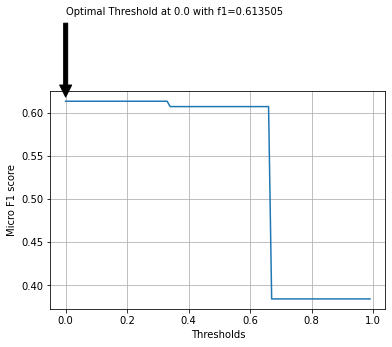

In [20]:
prob=model.predict_proba(X_test)
thresholds= np.arange(0,1,0.01)
f1_scores=[]

for th in thresholds:
  labels =(prob>th).astype('int')
  f1= f1_score(y_test,labels,average="micro")
  f1_scores.append(f1)

  
plt.plot(thresholds,f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('Micro F1 score')
ymax=max(f1_scores)
xpos=f1_scores.index(ymax)
xmax=thresholds[xpos]
plt.annotate(f"Optimal Threshold at %s with f1=%f"%(round(xmax,2),ymax),xy=(xmax,ymax),xytext=(xmax, ymax+0.1),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

### LSTM

In [ ]:
import pandas as pd

processed_df=pd.read_csv("/content/drive/MyDrive/ML Project/processed_questions.csv")
pd.set_option('display.max_colwidth', None)
processed_df

In [ ]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Input
from tensorflow.keras.layers import Dropout

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

num_words = 50000 # this means 15000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
tokenizer.fit_on_texts(processed_df["Question"])
X = tokenizer.texts_to_sequences(processed_df["Question"])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 200
X_pad= pad_sequences(X,maxlen,padding='post')


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.1, shuffle=True)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27943, 200) (3105, 200) (27943, 100) (3105, 100)


Using Glove word embeddings

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/ML Project/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(100, activation='sigmoid'))
# model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


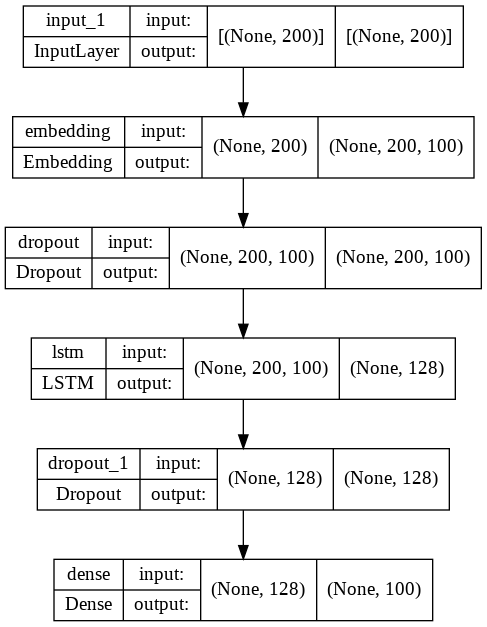

In [ ]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/ML Project/lstm_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

mc = ModelCheckpoint('./model.h5', monitor = 'val_loss', mode = 'max', verbose = 1, save_best_only = True)

history_embedding =model.fit(X_train,y_train,epochs=100,batch_size=120,validation_split=0.2,callbacks=[mc])

Epoch 1/100
187/187 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.0448
Epoch 1: val_loss improved from -inf to 0.07782, saving model to ./model.h5
187/187 [==============================] - 18s 70ms/step - loss: 0.1347 - accuracy: 0.0448 - val_loss: 0.0778 - val_accuracy: 0.0768
Epoch 2/100
187/187 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.0575
Epoch 2: val_loss improved from 0.07782 to 0.07791, saving model to ./model.h5
187/187 [==============================] - 11s 56ms/step - loss: 0.0809 - accuracy: 0.0575 - val_loss: 0.0779 - val_accuracy: 0.0657
Epoch 3/100
187/187 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.0539
Epoch 3: val_loss did not improve from 0.07791
187/187 [==============================] - 10s 53ms/step - loss: 0.0807 - accuracy: 0.0539 - val_loss: 0.0778 - val_accuracy: 0.0447
Epoch 4/100
187/187 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.0619
Epoch 4: va

In [ ]:
pickle.dump(model,open('/content/drive/MyDrive/ML Project/lstm_model.pkl','wb'))

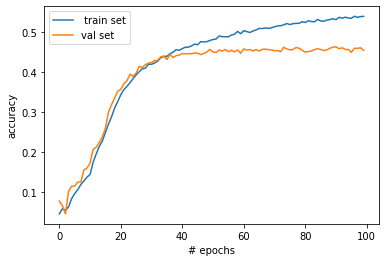

In [ ]:
plt.plot(history_embedding.history["accuracy"],label=" train set")
plt.plot(history_embedding.history["val_accuracy"],label="val set")
plt.xlabel('# epochs')
plt.ylabel("accuracy")
plt.legend()
plt.show()

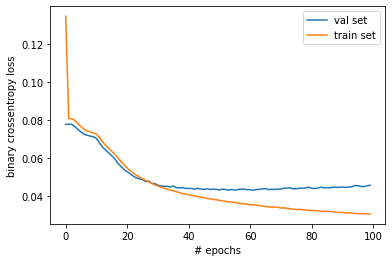

In [ ]:

plt.plot(history_embedding.history["val_loss"],label="val set")
plt.plot(history_embedding.history["loss"],label="train set")
plt.xlabel('# epochs')
plt.ylabel("binary crossentropy loss")
plt.legend()
plt.show()

In [ ]:
prob=model.predict(X_test)
thresholds=np.arange(0,1,0.01)
f1_scores=[]

for th in thresholds:
  labels =(prob>th).astype('int')
  f1= f1_score(y_test,labels,average="micro")
  f1_scores.append(f1)

# print(classification_report(y_train,y_pred))


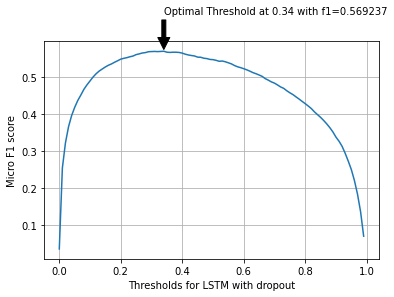

In [ ]:
# plt.figure(figsize=(8,12))  
plt.plot(thresholds,f1_scores)
plt.grid()
plt.xlabel('Thresholds for LSTM with dropout')
plt.ylabel('Micro F1 score')
ymax=max(f1_scores)
xpos=f1_scores.index(ymax)
xmax=thresholds[xpos]
plt.annotate(f"Optimal Threshold at %s with f1=%f"%(xmax,ymax),xy=(xmax,ymax),xytext=(xmax, ymax+0.1),arrowprops=dict(facecolor='black', shrink=0.05))
plt.savefig("/content/drive/MyDrive/ML Project/Plots/LSTM2.png")
plt.show()

In [ ]:
max_f1_dropout=ymax

In [ ]:
max_f1=ymax

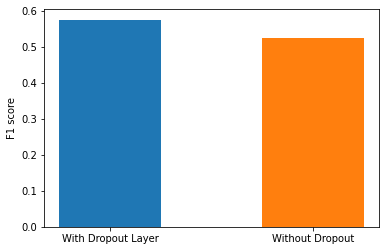

In [ ]:
plt.bar(0.8,max_f1_dropout,0.2,label="With Dropout")
plt.bar(1.2,max_f1,0.2,label="Without Dropout")
plt.xticks([0.8,1.2],['With Dropout Layer','Without Dropout'])
plt.ylabel("F1 score")
# plt.legend()
plt.show()


### BERT

In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

     |████████████████████████████████| 4.2 MB 8.2 MB/s 
     |████████████████████████████████| 596 kB 62.2 MB/s 
     |████████████████████████████████| 6.6 MB 42.1 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
processed_df.head()

,Unnamed: 0,Question,Code,Tag
0,0,prevent firefox close press ctrl-whow prevent ...,[],firefox
1,1,stop window 7 fade window alt-tab stop window ...,[],windows-7
2,2,get +ve number count linqget +ve number count ...,"['int[] a = {1, 2, 3, 0, 5, 0};\nint x = a.sel...",c# .net linq
3,3,implement static librari new iphon appimpl sta...,[],iphone xcode
4,4,tag `` swallow '' html tag `` swallow '' html ...,['&lt;html&gt;\n&lt;head&gt;\n &lt;title&gt...,html


In [ ]:
token = tokenizer.encode_plus(
    processed_df['Question'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
token

In [ ]:
def generate_training_data(df, tokenizer):
    ids=np.zeros((len(df),256))
    masks=np.zeros((len(df),256))
    for i, text in tqdm(enumerate(df['Question'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
input_ids,input_masks = generate_training_data(processed_df,tokenizer)

0it [00:00, ?it/s]

In [ ]:
input_ids.shape,input_masks.shape

((31048, 256), (31048, 256))

In [ ]:
labels = multilabel_y.todense()
labels.shape

(31048, 100)

In [ ]:
dataset1 = tf.data.Dataset.from_tensor_slices((input_ids, input_masks, labels))
dataset = tf.data.Dataset.from_tensor_slices((input_ids, input_masks, labels))
len(dataset)

31048

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'input_mask': attn_masks
    }, labels
  
dataset = dataset.map(SentimentDatasetMapFunction) 

In [ ]:
len(dataset)

31048

In [ ]:
dataset = dataset.shuffle(10000).batch(16,drop_remainder=True) # batch size, drop any left out tensor

In [ ]:
p = 0.8
train_size = int((len(processed_df)//16)*p) 

In [ ]:
train_size

1552

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained('bert-base-cased') 

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='input_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(100, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
sentiment_model.compile(optimizer=optim, loss=loss_func,  metrics=[acc])

In [ ]:
import joblib
sentiment_model=joblib.load("/content/drive/MyDrive/ML Project/bert.pkl")

In [ ]:
hist = sentiment_model.fit(
    train_dataset,
    # validation_data=val_dataset,
    epochs=10
)

In [ ]:
import joblib
joblib.dump(sentiment_model, 'bert.pkl')

In [ ]:
y_test = []
for i in val_dataset:
  y_test.append(i[1])

In [ ]:
y_test = []
for i in val_dataset:
  for j in i[1]:
    y_test.append(np.array(j))

In [ ]:
prob=sentiment_model.predict(val_dataset)
thresholds= np.arange(0,1,0.01)
f1_scores=[]

for th in thresholds:
  labels =(prob>th).astype('int')
  f1= f1_score(y_test,labels,average="micro")
  f1_scores.append(f1)

  
plt.plot(thresholds,f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('Micro F1 score')
ymax=max(f1_scores)
xpos=f1_scores.index(ymax)
xmax=thresholds[xpos]
plt.annotate(f"Optimal Threshold at %s"%xmax,xy=(xmax,ymax),xytext=(xmax, ymax+0.1),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

KeyboardInterrupt: ignored

In [ ]:
bert_model = joblib.load('bert.pkl')